# Интернет-магазин товаров для дома и быта «Пока все ещё тут». Сегментирование покупателей по профилю потребления.

***Задача:***
Сегментировать покупателей по профилю потребления.
•	Проведите исследовательский анализ данных
•	Сегментируйте покупателей на основе истории их покупок Не бойтесь выдвигать собственные варианты сегментации покупателей. Задумайтесь о том как сегментация может помочь в разработке более персонализированных предложений для покупателей? Попробуйте сформировать сегменты на основе того, что покупают пользователи. Для этого вы можете проанализировать их покупки и сегментировать товары на основе принадлежности к той или иной товарной категории.
•	Сформулируйте и проверьте статистические гипотезы

## Загрузка данных и подготовка их к анализу.

In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import math as mth
#!pip install pymystem3
from pymystem3 import Mystem
m = Mystem()
#!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [2]:
if os.path.exists('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv'):
    ecom_data = pd.read_csv('https://code.s3.yandex.net/datasets/ecommerce_dataset.csv')
else:
    ecom_data = pd.read_csv('C:/Users/user/Documents/Проекты ЯП/Выпускной проект/ecommerce_dataset.csv')

In [3]:
ecom_data.head(10)# посмотрим на данные

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


In [4]:
round((ecom_data.isna().mean()*100), 2) # проверим на пропуски

date           0.0
customer_id    0.0
order_id       0.0
product        0.0
quantity       0.0
price          0.0
dtype: float64

In [5]:
round((ecom_data.isnull().mean()*100),2) # проверим на 0

date           0.0
customer_id    0.0
order_id       0.0
product        0.0
quantity       0.0
price          0.0
dtype: float64

In [6]:
ecom_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


***Описание данных***

- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.

In [7]:
ecom_data['date'] = pd.to_datetime(ecom_data['date'], format='%Y%m%d%H') # преобразуем тип данных в datetime
#ecom_data['date'] = pd.to_datetime(ecom_data['date_time'].dt.date)
#ecom_data['date'] = pd.to_datetime((pd.to_datetime(ecom_data['date'], format='%Y%m%d%H')).dt.date) # преобразуем тип данных в дату
#ecom_data.info()

In [8]:
ecom_data.duplicated().sum() # проверим на дубликаты

0

При подготовке данных к анализу пропусков и дубликатов не обнаружено. Всего исходная таблица содержит 6 столбцов и 6737 строк. Данные столбца date приведены к типу datetime для дальнейшего использования.

# Исследовательский анализ данных.

## Определить за какой период времени и по какому количеству покупателей есть данные. 

In [9]:
print('Всего покупателей:', ecom_data['customer_id'].nunique())
print('Всего заказов:', ecom_data['order_id'].nunique())

Всего покупателей: 2451
Всего заказов: 2784


In [10]:
print('В среднем на покупателя приходится {} заказ.'.format(round((ecom_data['order_id'].nunique() / ecom_data['customer_id'].nunique()), 2)))

В среднем на покупателя приходится 1.14 заказ.


In [11]:
date_min = ecom_data['date'].min()
date_max = ecom_data['date'].max()
print('Миниимльная дата', date_min, '\n''Максимальная дата', date_max)

Миниимльная дата 2018-10-01 00:00:00 
Максимальная дата 2019-10-31 16:00:00


В работе у нас есть данные о покупках по 2451 клиенту за период с 1 октября 2018 года по 31 октября 2019 года. В среднем клиенты делают одну покупку в магазине.

## Построить распределение покупок по сумме.

In [12]:
ecom_data.describe().T # посмотрим на min, max и mean цены купленных товаров

,count,mean,std,min,25%,50%,75%,max
order_id,6737.0,43128.948345,27899.414662,12624.0,14827.0,68503.0,70504.0,73164.0
quantity,6737.0,2.501559,15.266478,1.0,1.0,1.0,1.0,1000.0
price,6737.0,462.028499,871.296064,9.0,101.0,135.0,398.0,14917.0


In [13]:
order_data = (ecom_data.pivot_table(values='price', index='order_id', aggfunc='sum')
              .reset_index()
              .sort_values(by='price', ascending=False)
              )
order_data.head(15) # Отдельно выведем номер заказа и его сумму

,order_id,price
221,14833,113220.0
1658,70960,65220.0
933,69531,49668.0
502,68760,43372.0
1754,71148,28784.0
222,14835,21770.0
1987,71633,16647.0
311,68474,16495.0
1866,71363,14995.0
2247,72139,14917.0


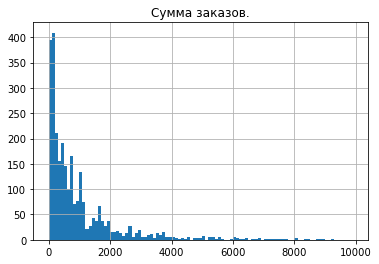

In [14]:
order_data['price'].hist(range=(10,100), bins=range(0, 10000, 100));
plt.title('Сумма заказов.')
plt.show()

In [15]:
#rrr = ecom_data.query('order_id == 13547')
#rrr

## Разбить купленные товары на категории. Создать дополнительный столбец. Построить графики зависимости суммы покупок от категории купленного товара.

In [ ]:
for text in ecom_data['product']:
    lemmas = m.lemmatize(text)
    print(text, lemmas)

Комнатное растение в горшке Алое Вера, d12, h30 ['комнатный', ' ', 'растение', ' ', 'в', ' ', 'горшок', ' ', 'алый', ' ', 'вера', ', ', 'd12', ', ', 'h30', '\n']
Комнатное растение в горшке Кофе Арабика, d12, h25 ['комнатный', ' ', 'растение', ' ', 'в', ' ', 'горшок', ' ', 'кофе', ' ', 'арабика', ', ', 'd12', ', ', 'h25', '\n']
Радермахера d-12 см h-20 см ['радермахер', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '20', ' ', 'см', '\n']
Хризолидокарпус Лутесценс d-9 см ['хризолидокарпус', ' ', 'лутесценс', ' ', 'd', '-', '9', ' ', 'см', '\n']
Циперус Зумула d-12 см h-25 см ['циперус', ' ', 'зумула', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '25', ' ', 'см', '\n']
Шеффлера Лузеана d-9 см ['шеффлер', ' ', 'лузеан', ' ', 'd', '-', '9', ' ', 'см', '\n']
Юкка нитчатая d-12 см h-25-35 см ['юкка', ' ', 'нитчатый', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '25', '-', '35', ' ', 'см', '\n']
Настенная сушилка для белья Gimi Brio Super 100 ['настенный', ' ', 'сушилка', ' ', 'для', ' '

Тарелка обеденная ЛИМОН ФИЦ 25см, G9547, Luminarc, Франция ['тарелка', ' ', 'обеденный', ' ', 'лимон', ' ', 'фиц', ' ', '25см', ', ', 'G9547', ', ', 'Luminarc', ', ', 'франция', '\n']
Вилка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR013 ['вилка', ' ', 'столовая', ' ', 'RIPPLE', ' ', 'сталь', ' ', '3', ' ', 'мм', ', ', '3', ' ', 'шт', ', ', 'Attribute', ', ', 'ACR013', '\n']
Ложка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR023 ['ложка', ' ', 'столовая', ' ', 'RIPPLE', ' ', 'сталь', ' ', '3', ' ', 'мм', ', ', '3', ' ', 'шт', ', ', 'Attribute', ', ', 'ACR023', '\n']
Ложка чайная RIPPLE сталь 2,5 мм, 3 шт, Attribute, ACR033 ['ложка', ' ', 'чайная', ' ', 'RIPPLE', ' ', 'сталь', ' ', '2', ',', '5', ' ', 'мм', ', ', '3', ' ', 'шт', ', ', 'Attribute', ', ', 'ACR033', '\n']
Нож столовый RIPPLE 80 г 2 шт, Attribute, ACR042 ['нож', ' ', 'столовый', ' ', 'RIPPLE', ' ', '80', ' ', 'г', ' ', '2', ' ', 'шт', ', ', 'Attribute', ', ', 'ACR042', '\n']
Герань домашняя (пеларгония зональная) цве

Муляж Груша, желтый, 9,5 см, полиуретан, Fancy Fair/ff LI95-01 ['муляж', ' ', 'груша', ', ', 'желтый', ', ', '9', ',', '5', ' ', 'см', ', ', 'полиуретан', ', ', 'Fancy', ' ', 'Fair', '/', 'ff', ' ', 'LI95', '-', '01', '\n']
Муляж Груша, желтый, 9,5 см, полиуретан, Fancy Fair/ff LI95-03 ['муляж', ' ', 'груша', ', ', 'желтый', ', ', '9', ',', '5', ' ', 'см', ', ', 'полиуретан', ', ', 'Fancy', ' ', 'Fair', '/', 'ff', ' ', 'LI95', '-', '03', '\n']
Муляж Мандарин, оранжевый, 8 см, полиуретан, Fancy Fair/ff JZ80 ['муляж', ' ', 'мандарин', ', ', 'оранжевый', ', ', '8', ' ', 'см', ', ', 'полиуретан', ', ', 'Fancy', ' ', 'Fair', '/', 'ff', ' ', 'JZ80', '\n']
Муляж Персик, оранжевый, 9 см, полиуретан, Fancy Fair/ff TZ90 ['муляж', ' ', 'персик', ', ', 'оранжевый', ', ', '9', ' ', 'см', ', ', 'полиуретан', ', ', 'Fancy', ' ', 'Fair', '/', 'ff', ' ', 'TZ90', '\n']
Набор фужеров Luminarc ДАМПЬЕР СИЛЬВЕР для вина 260 мл 6 шт H7939 ['набор', ' ', 'фужер', ' ', 'Luminarc', ' ', 'дампьер', ' ', 'сильвер

Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', '\n']
Толкушка для картофеля из нержавеющей стали Proline, Leifheit, 03032 ['толкушка', ' ', 'для', ' ', 'картофель', ' ', 'из', ' ', 'нержавеющий', ' ', 'сталь', ' ', 'Proline', ', ', 'Leifheit', ', ', '03032', '\n']
Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ ['тележка', ' ', 'багажный', ' ', 'DELTA', ' ', 'ТБР', '-', '20', ' ', 'коричневый', ' ', 'с', ' ', 'оранжевый', ' ', 'грузоподъемность', ' ', '25', ' ', 'кг', ' ', 'сумка', ' ', 'и', ' ', '50', ' ', 'кг', ' ', 'каркас', ' ', 'россия', '\n']
Готовая скатерть Ажурная Dia Rose круглая д.152 белая, 5173, Towa Co., LTD ['готовый', ' ', 'скатерть', ' ', 'ажурный', ' ', 'Dia', ' ', 'Rose', ' ', 'круглый', ' ', 'д', '.', '152', ' ', 'белый', ', ', '5173', ', ', 'Towa', ' ', 'Co', '.', ', ', 'LTD', '\n']
Сушилка для белья потолочная Z

Сумка для тележки большая комбинированная 45*30*25, 1209021 ['сумка', ' ', 'для', ' ', 'тележка', ' ', 'большой', ' ', 'комбинированный', ' ', '45', '*', '30', '*', '25', ', ', '1209021', '\n']
Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ ['тележка', ' ', 'багажный', ' ', 'DELTA', ' ', 'ТБР', '-', '20', ' ', 'синий', ' ', 'грузоподъемность', ' ', '25', ' ', 'кг', ' ', 'сумка', ' ', 'и', ' ', '50', ' ', 'кг', ' ', 'каркас', ' ', 'россия', '\n']
Стяжка оконная с болтом СТ-55 цинк, 1108354 ['стяжка', ' ', 'оконный', ' ', 'с', ' ', 'болт', ' ', 'ст', '-', '55', ' ', 'цинк', ', ', '1108354', '\n']
Сумка-тележка 3-х колесная Gimi Tris Floral синяя ['сумка', '-', 'тележка', ' ', '3', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Tris', ' ', 'Floral', ' ', 'синий', '\n']
Сумка-тележка хозяйственная Andersen Scala Shopper, Elba, черная 112-051-80 ['сумка', '-', 'тележка', ' ', 'хозяйственный', ' ', 'Andersen', ' ', 'Scala', ' ', 'Shopper', ', ', 'Elba',

Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014 ['пружина', ' ', 'дверной', ' ', '240', ' ', 'мм', ' ', 'оцинковывать', ' (', 'д', '-', '19', ' ', 'мм', ') ', 'без', ' ', 'крепление', ', ', '1107014', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиновая с красным, полумахровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'малиновый', ' ', 'с', ' ', 'красный', ', ', 'полумахровый', '\n']
Глоксиния d-13 см ['глоксиния', ' ', 'd', '-', '13', ' ', 'см', '\n']
Азалия индика Биколор d-12 см ['азалий', ' ', 'индик', ' ', 'биколор', ' ', 'd', '-', '12', ' ', 'см', '\n']
Гортензия Микс d-12 см ['гортензия', ' ', 'микс', ' ', 'd', '-', '12', ' ', 'см', '\n']
Хризантема Космо микс d-12 см ['хризантема', ' ', 'космо', ' ', 'микс', ' ', 'd', '-', '12', ' ', 'см', '\n']
Сушилка для белья потолочная Лиана 1,6 м 1703005 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' '

Нож столовый RIPPLE 80 г 2 шт, Attribute, ACR042 ['нож', ' ', 'столовый', ' ', 'RIPPLE', ' ', '80', ' ', 'г', ' ', '2', ' ', 'шт', ', ', 'Attribute', ', ', 'ACR042', '\n']
Сушилка для белья потолочно-настенная Gimi Lift 240, 5031 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочно', '-', 'настенный', ' ', 'Gimi', ' ', 'Lift', ' ', '240', ', ', '5031', '\n']
Сушилка для белья Gimi Lampo ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Gimi', ' ', 'Lampo', '\n']
Сумка-тележка хозяйственная Gimi Market синяя ['сумка', '-', 'тележка', ' ', 'хозяйственный', ' ', 'Gimi', ' ', 'Market', ' ', 'синий', '\n']
Tepмокружка AVEX Recharge 500 мл голубой AVEX0681 ['термокружок', ' ', 'AVEX', ' ', 'Recharge', ' ', '500', ' ', 'мл', ' ', 'голубой', ' ', 'AVEX0681', '\n']
Чехол для гладильной доски Zalger 520135 140х50 см хлопок поролон для доски 135х45 см ['чехол', ' ', 'для', ' ', 'гладильный', ' ', 'доска', ' ', 'Zalger', ' ', '520135', ' ', '140х50', ' ', 'см', ' ', 'хлопок', ' ', 'поролон', ' ', 'для'

Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиново розовая, простая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'малиновый', ' ', 'розовый', ', ', 'простой', '\n']
Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', '\n']
Сушилка для белья Gimi Jolly 18 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Gimi', ' ', 'Jolly', ' ', '18', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, ярко красная, махровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'ярко', ' ', 'красный', ', ', 'махровый', '\n']
Жидкое мыло Vestar Хозяйственное 750 мл Россия 4620757212370 ['жидкий', ' ', 'мыло', ' ', 'Vestar', ' ', 'хозяйственный', ' ', '750', ' ', 'мл', ' ', 'россия', ' ', '4620757212370', '\n']
Ковёр придверный "Лапша" 60

Контейнер для овощей Полимербыт 3-х секционный лоток 9 л 4312600 ['контейнер', ' ', 'для', ' ', 'овощ', ' ', 'полимербыт', ' ', '3', '-', 'х', ' ', 'секционный', ' ', 'лоток', ' ', '9', ' ', 'л', ' ', '4312600', '\n']
Сушилка для белья ЛИАНА ЛЮКС 130 см потолочная ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'лиана', ' ', 'люкс', ' ', '130', ' ', 'см', ' ', 'потолочный', '\n']
Кувшин пластмассовый с крышкой "Кумган" 2,0 л 1408003 ['кувшин', ' ', 'пластмассовый', ' ', 'с', ' ', 'крышка', ' "', 'кумган', '" ', '2', ',', '0', ' ', 'л', ' ', '1408003', '\n']
Контейнер для овощей Полимербыт 3-х секционный лоток 9 л 4312600 ['контейнер', ' ', 'для', ' ', 'овощ', ' ', 'полимербыт', ' ', '3', '-', 'х', ' ', 'секционный', ' ', 'лоток', ' ', '9', ' ', 'л', ' ', '4312600', '\n']
Стремянка алюминиевая 5 ступеней, СА5, НИКА ['стремянка', ' ', 'алюминиевый', ' ', '5', ' ', 'ступень', ', ', 'СА5', ', ', 'ника', '\n']
Чехол для гладильной доски UNIVERSAL 160х60 см, Attribute, ABU004 ['чехол', ' ', 'для'

Муляж ГРАНАТ 9 см красный ['муляж', ' ', 'гранат', ' ', '9', ' ', 'см', ' ', 'красный', '\n']
Гладильная доска Sarayli New Elegant 125x45 см ['гладильный', ' ', 'доска', ' ', 'Sarayli', ' ', 'New', ' ', 'Elegant', ' ', '125x45', ' ', 'см', '\n']
Салфетка Protec Textil Polyline 30х43 см Аметист белая 6230 ['салфетка', ' ', 'Protec', ' ', 'Textil', ' ', 'Polyline', ' ', '30х43', ' ', 'см', ' ', 'аметист', ' ', 'белый', ' ', '6230', '\n']
Кувшин пластмассовый с крышкой "Кумган" 2,0 л 1408003 ['кувшин', ' ', 'пластмассовый', ' ', 'с', ' ', 'крышка', ' "', 'кумган', '" ', '2', ',', '0', ' ', 'л', ' ', '1408003', '\n']
Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'настенный', ' ', 'Zalger', ' ', 'Prima', ' ', '510', '-', '720', ' ', 'веревочный', ' ', '7', ' ', 'линия', ' ', '25', ' ', 'м', '\n']
Лестница-стремянка Dogrular Ufuk Al алюминевая 6-ти ступенчатая ['лестница', '-', 'стремянка', ' ', 'Dogrular', ' ', 'Ufuk', ' 

Коробка для хранения на молнии из синтетического волокна Hausmann, 35,5х20,5х13,5 см, зеленая, BB211-3 ['коробка', ' ', 'для', ' ', 'хранение', ' ', 'на', ' ', 'молния', ' ', 'из', ' ', 'синтетический', ' ', 'волокно', ' ', 'Hausmann', ', ', '35', ',', '5х20', ',', '5х13', ',', '5', ' ', 'см', ', ', 'зеленый', ', ', 'BB211', '-', '3', '\n']
Кофр для хранения медикаментов Hausmann 9 отделений 30x22x12 см 4W-107 ['кофр', ' ', 'для', ' ', 'хранение', ' ', 'медикамент', ' ', 'Hausmann', ' ', '9', ' ', 'отделение', ' ', '30x22x12', ' ', 'см', ' ', '4W', '-', '107', '\n']
Набор вешалок мягких тканевых с перекладиной 38х15 см 2 шт Валиант / Valiant VAL 7054sb ['набор', ' ', 'вешалка', ' ', 'мягкий', ' ', 'тканевый', ' ', 'с', ' ', 'перекладина', ' ', '38х15', ' ', 'см', ' ', '2', ' ', 'шт', ' ', 'валиант', ' / ', 'Valiant', ' ', 'VAL', ' ', '7054sb', '\n']
Наматрасник Wellness WM180, 100% хлопок, 180х200 см, стеганый белый, 4607101067749 ['наматрасник', ' ', 'Wellness', ' ', 'WM180', ', ', '1

Коробка для хранения на молнии из синтетического волокна Hausmann, 35,5х20,5х13,5 см, зеленая, BB211-3 ['коробка', ' ', 'для', ' ', 'хранение', ' ', 'на', ' ', 'молния', ' ', 'из', ' ', 'синтетический', ' ', 'волокно', ' ', 'Hausmann', ', ', '35', ',', '5х20', ',', '5х13', ',', '5', ' ', 'см', ', ', 'зеленый', ', ', 'BB211', '-', '3', '\n']
Кофр для хранения медикаментов Hausmann 9 отделений 30x22x12 см 4W-107 ['кофр', ' ', 'для', ' ', 'хранение', ' ', 'медикамент', ' ', 'Hausmann', ' ', '9', ' ', 'отделение', ' ', '30x22x12', ' ', 'см', ' ', '4W', '-', '107', '\n']
Наматрасник Wellness WM180, 100% хлопок, 180х200 см, стеганый белый, 4607101067749 ['наматрасник', ' ', 'Wellness', ' ', 'WM180', ', ', '100', '% ', 'хлопок', ', ', '180х200', ' ', 'см', ', ', 'стеганый', ' ', 'белый', ', ', '4607101067749', '\n']
Наматрицник-чехол Natures Стебель бамбука СБ-Н-1-1 односпальный, бамбуковый, 90х200 см, молочный ['наматрицник', '-', 'чехол', ' ', 'Natures', ' ', 'стебель', ' ', 'бамбук', ' ', 

Рассада зелени для кухни Тимьяна в кассете по 6 шт ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '6', ' ', 'шт', '\n']
Сиденье в ванну раздвижное, белый, СВ5, НИКА ['сидение', ' ', 'в', ' ', 'ванна', ' ', 'раздвижной', ', ', 'белый', ', ', 'СВ5', ', ', 'ника', '\n']
Сушилка для белья Gimi Extension ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Gimi', ' ', 'Extension', '\n']
Масленка КОРОВКА с крышкой 17см, 73115, Luminarc, Франция ['масленка', ' ', 'коровка', ' ', 'с', ' ', 'крышка', ' ', '17см', ', ', '73115', ', ', 'Luminarc', ', ', 'франция', '\n']
Вешалка для блузок 41 см черный Attribute AHM791 ['вешалка', ' ', 'для', ' ', 'блузка', ' ', '41', ' ', 'см', ' ', 'черный', ' ', 'Attribute', ' ', 'AHM791', '\n']
Коврик влаговпитывающий ребристый 50х80 см Стандарт черный 5877 ['коврик', ' ', 'влаговпитывающий', ' ', 'ребристый', ' ', '50х80', ' ', 'см', ' ', 'стандарт', ' ', 'черный', ' ', '5877', '\n']
Коврик влаговпитывающи

Многолетнее растение Тимьян-чабрец розовый объем 0,5 л ['многолетний', ' ', 'растение', ' ', 'тимьян', '-', 'чабрец', ' ', 'розовый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Пеларгония зональная диам. 12 см белая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'белый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см розовая с малиновым полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'розовый', ' ', 'с', ' ', 'малиновый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см сиреневый полумахровый ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'сиреневый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см ярко красная махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'ярко', ' ', 'красный', ' ', 'махровый', '\n']
Рассада зелени для кухни Лаванды в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухн

Пеларгония розоцветная РЕД РОЗЕБУД молодые растения ['пеларгония', ' ', 'розоцветный', ' ', 'ред', ' ', 'розебуд', ' ', 'молодой', ' ', 'растение', '\n']
Гладильная доска НИКА SOPHY КОРИЦА HSK 123х46 см ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'SOPHY', ' ', 'корица', ' ', 'HSK', ' ', '123х46', ' ', 'см', '\n']
Кувшин пластмассовый с крышкой "Кумган" 2,0 л 1408003 ['кувшин', ' ', 'пластмассовый', ' ', 'с', ' ', 'крышка', ' "', 'кумган', '" ', '2', ',', '0', ' ', 'л', ' ', '1408003', '\n']
Коврик противоскользящий пузырьки 70х38 см прозрачный 5523 ['коврик', ' ', 'противоскользящий', ' ', 'пузырек', ' ', '70х38', ' ', 'см', ' ', 'прозрачный', ' ', '5523', '\n']
Чехол для гладильной доски универсальный с поролоном 2, 1290 х 500, ЧП2, НИКА ['чехол', ' ', 'для', ' ', 'гладильный', ' ', 'доска', ' ', 'универсальный', ' ', 'с', ' ', 'поролон', ' ', '2', ', ', '1290', ' ', 'х', ' ', '500', ', ', 'ЧП2', ', ', 'ника', '\n']
Сумка-тележка хозяйственная GIMI Argo голубая ['сумка', '-', 'теле

Шнур резиновый для тележки 110 см, 1209002 ['шнур', ' ', 'резиновый', ' ', 'для', ' ', 'тележка', ' ', '110', ' ', 'см', ', ', '1209002', '\n']
Шнур резиновый для тележки 80 см, 1209001 ['шнур', ' ', 'резиновый', ' ', 'для', ' ', 'тележка', ' ', '80', ' ', 'см', ', ', '1209001', '\n']
Рассада зелени для кухни Душицы в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'душица', ' ', 'в', ' ', 'горшок', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Мелиссы в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'мелисса', ' ', 'в', ' ', 'горшок', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Розмарина в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'розмарин', ' ', 'в', ' ', 'горшок', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Тимьяна в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'в', ' ', 'горшок', ' '

Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиново розовая, простая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'малиновый', ' ', 'розовый', ', ', 'простой', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, розовая с малиновым, полумахровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'розовый', ' ', 'с', ' ', 'малиновый', ', ', 'полумахровый', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, розовая, махровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'розовый', ', ', 'махровый', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, сиренево-красная, простая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'с

Муляж Тыквы d-8 см ['муляж', ' ', 'тыква', ' ', 'd', '-', '8', ' ', 'см', '\n']
Вилка столовая Better цветной горох BT-C2003E-TD1/D1 ['вилка', ' ', 'столовая', ' ', 'Better', ' ', 'цветной', ' ', 'горох', ' ', 'BT', '-', 'C2003E', '-', 'TD1', '/', 'D1', '\n']
Контейнер для приготовления 2-х яиц ГЛАЗУНЬЯ Полимербыт C452 ['контейнер', ' ', 'для', ' ', 'приготовление', ' ', '2', '-', 'х', ' ', 'яйцо', ' ', 'глазунья', ' ', 'полимербыт', ' ', 'C452', '\n']
Кружка 350 мл ROSARIO Радуга керамическая коричневый Ф13-005L ['кружка', ' ', '350', ' ', 'мл', ' ', 'ROSARIO', ' ', 'радуга', ' ', 'керамический', ' ', 'коричневый', ' ', 'Ф13', '-', '005L', '\n']
Кружка для чая Ягода клубника 250 мл 1606-Д ['кружка', ' ', 'для', ' ', 'чай', ' ', 'ягода', ' ', 'клубника', ' ', '250', ' ', 'мл', ' ', '1606', '-', 'д', '\n']
Кружка Luminarc ЛИЛИ ФЛАУЭР 320 мл J8565-1 ['кружка', ' ', 'Luminarc', ' ', 'лили', ' ', 'флауэр', ' ', '320', ' ', 'мл', ' ', 'J8565', '-', '1', '\n']
Ложка обувная металлическая кра

Средство для удаления известкового налета с поверхностей сантехнических приборов DECS Антикальций 500 мл Россия 4660015923266 ['средство', ' ', 'для', ' ', 'удаление', ' ', 'известковый', ' ', 'налет', ' ', 'с', ' ', 'поверхность', ' ', 'сантехнический', ' ', 'прибор', ' ', 'DECS', ' ', 'антикальций', ' ', '500', ' ', 'мл', ' ', 'россия', ' ', '4660015923266', '\n']
Герань домашняя (пеларгония зональная) цветущая , D12, H25-30, красная, махровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' , ', 'D12', ', ', 'H25', '-', '30', ', ', 'красный', ', ', 'махровый', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, белая, махровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'белый', ', ', 'махровый', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') 

Рассада зелени для кухни Тимьяна в кассете по 6 шт ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '6', ' ', 'шт', '\n']
Муляж Морковь 16 см ['муляж', ' ', 'морковь', ' ', '16', ' ', 'см', '\n']
Муляж Виноград желтый 24 см полиуретан ['муляж', ' ', 'виноград', ' ', 'желтый', ' ', '24', ' ', 'см', ' ', 'полиуретан', '\n']
Муляж Груша желтый 9,5 см полиуретан ['муляж', ' ', 'груша', ' ', 'желтый', ' ', '9', ',', '5', ' ', 'см', ' ', 'полиуретан', '\n']
Муляж Желудь 2 шт ['муляж', ' ', 'желудь', ' ', '2', ' ', 'шт', '\n']
Муляж Лимон желтый 9 см полиуретан ['муляж', ' ', 'лимон', ' ', 'желтый', ' ', '9', ' ', 'см', ' ', 'полиуретан', '\n']
Муляж Мандарин оранжевый 8 см полиуретан ['муляж', ' ', 'мандарин', ' ', 'оранжевый', ' ', '8', ' ', 'см', ' ', 'полиуретан', '\n']
Муляж Перец Чили мини 2 шт, красный 7 см ['муляж', ' ', 'перец', ' ', 'чили', ' ', 'мини', ' ', '2', ' ', 'шт', ', ', 'красный', ' ', '7', ' ', 'см', '\n']
Муляж

Сумка-тележка GIMI Argo красная ['сумка', '-', 'тележка', ' ', 'GIMI', ' ', 'Argo', ' ', 'красный', '\n']
Салфетка Protec Textil Lino 30х43 см шоколад 6222 ['салфетка', ' ', 'Protec', ' ', 'Textil', ' ', 'Lino', ' ', '30х43', ' ', 'см', ' ', 'шоколад', ' ', '6222', '\n']
Корзина для белья INFINITY CURVER 59 л белая 04754-N23-00 ['корзина', ' ', 'для', ' ', 'белье', ' ', 'INFINITY', ' ', 'CURVER', ' ', '59', ' ', 'л', ' ', 'белый', ' ', '04754', '-', 'N23', '-', '00', '\n']
Пробка для ванны резиновая с цепочкой 1206157 ['пробка', ' ', 'для', ' ', 'ванна', ' ', 'резиновый', ' ', 'с', ' ', 'цепочка', ' ', '1206157', '\n']
Сушилка МУЛЬТИ 10м (1002010520027), Attribute, ADM110 ['сушилка', ' ', 'мультя', ' ', '10м', ' (', '1002010520027', '), ', 'Attribute', ', ', 'ADM110', '\n']
Чехол для гладильной доски Zalger 520111 см металлизированный с поролоном для доски 120х42 см ['чехол', ' ', 'для', ' ', 'гладильный', ' ', 'доска', ' ', 'Zalger', ' ', '520111', ' ', 'см', ' ', 'металлизированный',

Калоцефалус Брауни крашеный осенний микс d-10 см ['калоцефалус', ' ', 'брауни', ' ', 'крашеный', ' ', 'осенний', ' ', 'микс', ' ', 'd', '-', '10', ' ', 'см', '\n']
Коврик придверный APACHE 45х76 см Flagstone 5415 ['коврик', ' ', 'придверный', ' ', 'APACHE', ' ', '45х76', ' ', 'см', ' ', 'Flagstone', ' ', '5415', '\n']
Антижир POSH ONE MAGNUM 828 мл Россия 4580390-927058 ['антижир', ' ', 'POSH', ' ', 'ONE', ' ', 'MAGNUM', ' ', '828', ' ', 'мл', ' ', 'россия', ' ', '4580390', '-', '927058', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, малиновая, махровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'малиновый', ', ', 'махровый', '\n']
Каллуна Гарден Герлс трехцветная d-12 см h-27 см ['каллун', ' ', 'гарден', ' ', 'герлс', ' ', 'трехцветный', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '27', ' ', 'см', '\n']
Капсикум Сальса оранжевый d-10 см ['капсикум', ' ', 'сальса', ' ', 'оранжевый',

Сушилка для белья потолочная Лиана 2,4 м 1703011 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', '2', ',', '4', ' ', 'м', ' ', '1703011', '\n']
Сушилка для белья ЛИАНА ЛЮКС 130 см потолочная ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'лиана', ' ', 'люкс', ' ', '130', ' ', 'см', ' ', 'потолочный', '\n']
Сушилка для белья потолочная Лиана 2,4 м 1703011 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', '2', ',', '4', ' ', 'м', ' ', '1703011', '\n']
Муляж Тыквы d-8 см ['муляж', ' ', 'тыква', ' ', 'd', '-', '8', ' ', 'см', '\n']
Сушилка для белья напольная Gimi Mito, алюминий ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'напольный', ' ', 'Gimi', ' ', 'Mito', ', ', 'алюминий', '\n']
Гладильная доска НИКА ВЕРОНА 1 чехол РЕТРО 122х42 см ДВ1р ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'верона', ' ', '1', ' ', 'чехол', ' ', 'ретро', ' ', '122х42', ' ', 'см', ' ', 'ДВ1р', '\n']
Швабра САЛЬСА треугольная МИНИ, Y8110 ['швабра', ' ', 'сальса', 

Гладильная доска НИКА SOPHY КОРИЦА HSK 123х46 см ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'SOPHY', ' ', 'корица', ' ', 'HSK', ' ', '123х46', ' ', 'см', '\n']
Сумка-тележка TWIN стальной каркас 56 л синяя, Gimi ['сумка', '-', 'тележка', ' ', 'TWIN', ' ', 'стальной', ' ', 'каркас', ' ', '56', ' ', 'л', ' ', 'синий', ', ', 'Gimi', '\n']
Гладильная доска Colombo Avantgard 120х40 см ['гладильный', ' ', 'доска', ' ', 'Colombo', ' ', 'Avantgard', ' ', '120х40', ' ', 'см', '\n']
Гладильная доска НИКА СТЕЛЛА Классик 2 122х34,5 см СТК2 ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'стелла', ' ', 'классик', ' ', '2', ' ', '122х34', ',', '5', ' ', 'см', ' ', 'СТК2', '\n']
Тарелка десертная ВОЛАРЭ БЛЭК 22,5 см G9399 Luminarc ['тарелка', ' ', 'десертный', ' ', 'воларэ', ' ', 'блэк', ' ', '22', ',', '5', ' ', 'см', ' ', 'G9399', ' ', 'Luminarc', '\n']
Сушилка для белья потолочная Лиана 1,5 м 1703004 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', '1', ',', '5', ' ',

Сушилка для белья потолочная Лиана 1,8 м 1703007 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', '1', ',', '8', ' ', 'м', ' ', '1703007', '\n']
Термометр на окно уличный на липучках Т-5 h-20 см 1210035 ['термометр', ' ', 'на', ' ', 'окно', ' ', 'уличный', ' ', 'на', ' ', 'липучка', ' ', 'т', '-', '5', ' ', 'h', '-', '20', ' ', 'см', ' ', '1210035', '\n']
Салатник ВОЛАРЭ БЛЭК 16 см G9403 Luminarc ['салатник', ' ', 'воларэ', ' ', 'блэк', ' ', '16', ' ', 'см', ' ', 'G9403', ' ', 'Luminarc', '\n']
Тарелка суповая ВОЛАРЭ БЛЭК 23 см G9402 Luminarc ['тарелка', ' ', 'суповой', ' ', 'воларэ', ' ', 'блэк', ' ', '23', ' ', 'см', ' ', 'G9402', ' ', 'Luminarc', '\n']
Салатник ВОЛАРЭ БЛЭК 16 см G9403 Luminarc ['салатник', ' ', 'воларэ', ' ', 'блэк', ' ', '16', ' ', 'см', ' ', 'G9403', ' ', 'Luminarc', '\n']
Тарелка суповая ВОЛАРЭ БЛЭК 23 см G9402 Luminarc ['тарелка', ' ', 'суповой', ' ', 'воларэ', ' ', 'блэк', ' ', '23', ' ', 'см', ' ', 'G9402', ' ', 'Luminarc', '\n']
Аро

Сумка-тележка хозяйственная Gimi Easy Go синяя ['сумка', '-', 'тележка', ' ', 'хозяйственный', ' ', 'Gimi', ' ', 'Easy', ' ', 'Go', ' ', 'синий', '\n']
Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'настенный', ' ', 'Zalger', ' ', 'Prima', ' ', '510', '-', '720', ' ', 'веревочный', ' ', '7', ' ', 'линия', ' ', '25', ' ', 'м', '\n']
Сушилка для белья НИКА СБ1 18 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'ника', ' ', 'СБ1', ' ', '18', ' ', 'м', '\n']
Сушилка для белья потолочная Zalger Lift Comfort 520 180 см 9 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'Zalger', ' ', 'Lift', ' ', 'Comfort', ' ', '520', ' ', '180', ' ', 'см', ' ', '9', ' ', 'м', '\n']
Сковорода алюминиевая с антипригарным покрытием MARBLE ALPENKOK d = 22 см AK-0037A/22N ['сковорода', ' ', 'алюминиевый', ' ', 'с', ' ', 'антипригарный', ' ', 'покрытие', ' ', 'MARBLE', ' ', 'ALPENKOK', ' ', 'd', ' = ', '22', ' ', 'см', ' ', 'AK', '

Муляж Мандарин оранжевый 8 см полиуретан ['муляж', ' ', 'мандарин', ' ', 'оранжевый', ' ', '8', ' ', 'см', ' ', 'полиуретан', '\n']
Термометр на окно уличный на липучках Т-5 h-20 см 1210035 ['термометр', ' ', 'на', ' ', 'окно', ' ', 'уличный', ' ', 'на', ' ', 'липучка', ' ', 'т', '-', '5', ' ', 'h', '-', '20', ' ', 'см', ' ', '1210035', '\n']
Термометр на окно уличный на липучках Т-5 h-20 см 1210035 ['термометр', ' ', 'на', ' ', 'окно', ' ', 'уличный', ' ', 'на', ' ', 'липучка', ' ', 'т', '-', '5', ' ', 'h', '-', '20', ' ', 'см', ' ', '1210035', '\n']
Гладильная доска Sarayli New Elegant 125x45 см ['гладильный', ' ', 'доска', ' ', 'Sarayli', ' ', 'New', ' ', 'Elegant', ' ', '125x45', ' ', 'см', '\n']
Вешалка-сушилка Gimi Paco ['вешалка', '-', 'сушилка', ' ', 'Gimi', ' ', 'Paco', '\n']
Коврик Bacchetta противоскользящий в душевую кабину 55х55 см бежевый 4819 ['коврик', ' ', 'Bacchetta', ' ', 'противоскользящий', ' ', 'в', ' ', 'душевая', ' ', 'кабина', ' ', '55х55', ' ', 'см', ' ', 'беж

Ёрш унитазный с деревянной ручкой , Ваир 1712012 ['ерш', ' ', 'унитазный', ' ', 'с', ' ', 'деревянный', ' ', 'ручка', ' , ', 'ваир', ' ', '1712012', '\n']
Ель канадская Коника ртк 303 горшок 9 л Нидерланды ['ель', ' ', 'канадский', ' ', 'коника', ' ', 'ртк', ' ', '303', ' ', 'горшок', ' ', '9', ' ', 'л', ' ', 'нидерланды', '\n']
Кипарисовик лавсона Элвуди ртк 106 горшок 9 л Нидерланды ['кипарисовик', ' ', 'лавсон', ' ', 'элвуди', ' ', 'ртк', ' ', '106', ' ', 'горшок', ' ', '9', ' ', 'л', ' ', 'нидерланды', '\n']
Коврик противоскользящий камешки с ракушками овальный 69х39 см голубой 5520 ['коврик', ' ', 'противоскользящий', ' ', 'камешек', ' ', 'с', ' ', 'ракушка', ' ', 'овальный', ' ', '69х39', ' ', 'см', ' ', 'голубой', ' ', '5520', '\n']
Аптения d-10 см h-10 см ['аптений', ' ', 'd', '-', '10', ' ', 'см', ' ', 'h', '-', '10', ' ', 'см', '\n']
Сушилка для белья потолочная ЛИАНА ЛЮКС 170 см ЛЛП-170 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', 'люкс', ' ', 

Банка стеклянная с крышкой Attribute FLEUR 650 мл ABF135W ['банка', ' ', 'стеклянный', ' ', 'с', ' ', 'крышка', ' ', 'Attribute', ' ', 'FLEUR', ' ', '650', ' ', 'мл', ' ', 'ABF135W', '\n']
Мыльница пластмассовая на ванну М2221 1702010 ['мыльница', ' ', 'пластмассовый', ' ', 'на', ' ', 'ванна', ' ', 'М2221', ' ', '1702010', '\n']
Подголовник Bacchetta 25х34 см Quadrifoglio 4809 ['подголовник', ' ', 'Bacchetta', ' ', '25х34', ' ', 'см', ' ', 'Quadrifoglio', ' ', '4809', '\n']
Сушилка для белья Gimi Modular 3 Lux Silver ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Gimi', ' ', 'Modular', ' ', '3', ' ', 'Lux', ' ', 'Silver', '\n']
Коврик Dasch для ванной комнаты 50х80 см TL-90 Листопад зеленый 5730 ['коврик', ' ', 'Dasch', ' ', 'для', ' ', 'ванный', ' ', 'комната', ' ', '50х80', ' ', 'см', ' ', 'TL', '-', '90', ' ', 'листопад', ' ', 'зеленый', ' ', '5730', '\n']
Кружка прозрачная 250 мл H8437 Luminarc Франция ['кружка', ' ', 'прозрачный', ' ', '250', ' ', 'мл', ' ', 'H8437', ' ', 'Luminarc',

Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', '\n']
Крассула d-17 см h-40 см ['крассула', ' ', 'd', '-', '17', ' ', 'см', ' ', 'h', '-', '40', ' ', 'см', '\n']
Крючок одежный двойной усиленный алюминиевый (дюраль), 1110015 ['крючок', ' ', 'одежный', ' ', 'двойной', ' ', 'усиленный', ' ', 'алюминиевый', ' (', 'дюраль', '), ', '1110015', '\n']
Сушилка для белья потолочная Лиана 1,6 м 1703005 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', '1', ',', '6', ' ', 'м', ' ', '1703005', '\n']
Тарелка суповая ИРИС 21 см J1299 Luminarc ['тарелка', ' ', 'суповой', ' ', 'ирис', ' ', '21', ' ', 'см', ' ', 'J1299', ' ', 'Luminarc', '\n']
Комплект махровых салфеток ТОП_2, 100% хлопок 266 г/м2, 28х42 см, 2 шт, цвета в ассортименте, Wellness, 4630005364393 ['комплект', ' ', 'махровый', ' ', 'салфетка', ' ', 'топ', '_', '2', ', ', '100', '% ', 'хлопок', ' ', '266', ' ', 'г', '/',

Муляж Яблоко зеленый 9 см полиуретан ['муляж', ' ', 'яблоко', ' ', 'зеленый', ' ', '9', ' ', 'см', ' ', 'полиуретан', '\n']
Сушилка для белья потолочная ЛИАНА ЛЮКС 180 см ЛЛП-180 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', 'люкс', ' ', '180', ' ', 'см', ' ', 'ЛЛП', '-', '180', '\n']
Новогоднее дерево Ель сербская d-21 см h-60 см ['новогодний', ' ', 'дерево', ' ', 'ель', ' ', 'сербский', ' ', 'd', '-', '21', ' ', 'см', ' ', 'h', '-', '60', ' ', 'см', '\n']
Плед флисовый 200х150 см WELLNESS WPLNY152-Зима_4 100 % полиэстер ['плед', ' ', 'флисовый', ' ', '200х150', ' ', 'см', ' ', 'WELLNESS', ' ', 'WPLNY152', '-', 'зима', '_', '4', ' ', '100', ' % ', 'полиэстер', '\n']
Термометр на окно уличный на липучках Т-5 h-20 см 1210035 ['термометр', ' ', 'на', ' ', 'окно', ' ', 'уличный', ' ', 'на', ' ', 'липучка', ' ', 'т', '-', '5', ' ', 'h', '-', '20', ' ', 'см', ' ', '1210035', '\n']
Термометр на окно уличный на липучках Т-5 h-20 см 1210035 ['термометр', ' ', 'на'

Доска разделочная Alparaisa стеклянная Завтрак 20х30 см RD0030-ST ['доска', ' ', 'разделочный', ' ', 'Alparaisa', ' ', 'стеклянный', ' ', 'завтрак', ' ', '20х30', ' ', 'см', ' ', 'RD0030', '-', 'ST', '\n']
Лестница-стремянка Dogrular Ufuk оцинкованная 8-ми ступенчатая ['лестница', '-', 'стремянка', ' ', 'Dogrular', ' ', 'Ufuk', ' ', 'оцинковывать', ' ', '8', '-', 'ми', ' ', 'ступенчатый', '\n']
Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', '\n']
Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', '\n']
Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', '\n']
Сумка-тележка 2-х колесная Gimi Argo синяя ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'синий', 

Циперус Зумула d-12 см h-25 см ['циперус', ' ', 'зумула', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '25', ' ', 'см', '\n']
Сушилка для белья напольная COLOMBO BELLA 20 м ST387 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'напольный', ' ', 'COLOMBO', ' ', 'BELLA', ' ', '20', ' ', 'м', ' ', 'ST387', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'коралловый', ', ', 'полумахровый', '\n']
Штора для ванной комнаты 240х200 Sintra бежевая текстильная 240х200 см 6039 ['штора', ' ', 'для', ' ', 'ванный', ' ', 'комната', ' ', '240х200', ' ', 'Sintra', ' ', 'бежевый', ' ', 'текстильный', ' ', '240х200', ' ', 'см', ' ', '6039', '\n']
Кондиционер для белья Sandokkaebi Soft Aroma Aqua Blue Свежесть океана флакон 2100 мл Корея 8801353-003494 ['кондиционер', ' ', 'для', ' ', 'белье', ' ', 'Sandokkaebi', ' ', 'Soft', ' ', 'Aroma', ' 

Коврик придверный полиэстер, 46х76 см, Drifted Nature, Изменчивость, Mohawk, 5007 ['коврик', ' ', 'придверный', ' ', 'полиэстер', ', ', '46х76', ' ', 'см', ', ', 'Drifted', ' ', 'Nature', ', ', 'изменчивость', ', ', 'Mohawk', ', ', '5007', '\n']
Коврик придверный Alpine Wrought Iron из полиэстера и переработанной резины 45x76 см, Apache, 4649 ['коврик', ' ', 'придверный', ' ', 'Alpine', ' ', 'Wrought', ' ', 'Iron', ' ', 'из', ' ', 'полиэстер', ' ', 'и', ' ', 'перерабатывать', ' ', 'резина', ' ', '45x76', ' ', 'см', ', ', 'Apache', ', ', '4649', '\n']
Бензин для зажигалок, 1205214 ['бензин', ' ', 'для', ' ', 'зажигалка', ', ', '1205214', '\n']
Стремянка Eurogold Colour 2х ступенчатая с противоскользящим покрытием, сталь 2022R/2122R ['стремянка', ' ', 'Eurogold', ' ', 'Colour', ' ', '2х', ' ', 'ступенчатый', ' ', 'с', ' ', 'противоскользящий', ' ', 'покрытие', ', ', 'сталь', ' ', '2022R', '/', '2122R', '\n']
Стремянка бытовая Framar Slimmy 4 ступени ['стремянка', ' ', 'бытовой', ' ', 'Fr

Пеларгония зональная диам. 12 см темнорозовая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'темнорозовый', ' ', 'полумахровый', '\n']
Пеларгония зональная простая цвет фуксии ['пеларгония', ' ', 'зональный', ' ', 'простой', ' ', 'цвет', ' ', 'фуксия', '\n']
Пеларгония зональная РОЗОЦВЕТНАЯ Маргарита лососевая 5-7 листов ['пеларгония', ' ', 'зональный', ' ', 'розоцветный', ' ', 'маргарита', ' ', 'лососевый', ' ', '5', '-', '7', ' ', 'лист', '\n']
Пеларгония розоцветная РЕД РОЗЕБУД молодые растения ['пеларгония', ' ', 'розоцветный', ' ', 'ред', ' ', 'розебуд', ' ', 'молодой', ' ', 'растение', '\n']
Блюдце УТРО ЭКЛИПС, J3261, Luminarc, Франция ['блюдце', ' ', 'утро', ' ', 'эклипсы', ', ', 'J3261', ', ', 'Luminarc', ', ', 'франция', '\n']
Скатерть Ажурная d-ia Rose круглая д.152 белая 5173 Towa Co. LTd- ['скатерть', ' ', 'ажурный', ' ', 'd', '-', 'ia', ' ', 'Rose', ' ', 'круглый', ' ', 'д', '.', '152', ' ', 'белый', ' ', '5173', ' ', 'Towa', ' ', '

Пеларгония зональная диам. 12 см малиновая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'малиновый', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см розово-малиновая простая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'розовый', '-', 'малиновый', ' ', 'простой', '\n']
Пеларгония зональная диам. 12 см сиреневый полумахровый ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'сиреневый', ' ', 'полумахровый', '\n']
Шеффлера Лузеана d-9 см ['шеффлер', ' ', 'лузеан', ' ', 'd', '-', '9', ' ', 'см', '\n']
Вешалка деревянная с расширенными плечиками и перекладиной 44,5х23 см см серый JAPANESE BLACK VALIANT JB-19708 ['вешалка', ' ', 'деревянный', ' ', 'с', ' ', 'расширять', ' ', 'плечики', ' ', 'и', ' ', 'перекладина', ' ', '44', ',', '5х23', ' ', 'см', ' ', 'см', ' ', 'серый', ' ', 'JAPANESE', ' ', 'BLACK', ' ', 'VALIANT', ' ', 'JB', '-', '19708', '\n']
Комнатное растение в горшке Сциндапсус зеле

Защитная соль для посудомоечных машин Ludwik 1,5 кг Польша 5900861242227 ['защитный', ' ', 'соль', ' ', 'для', ' ', 'посудомоечный', ' ', 'машина', ' ', 'Ludwik', ' ', '1', ',', '5', ' ', 'кг', ' ', 'польша', ' ', '5900861242227', '\n']
Защитная соль для посудомоечных машин Ludwik 1,5 кг Польша 5900861242227 ['защитный', ' ', 'соль', ' ', 'для', ' ', 'посудомоечный', ' ', 'машина', ' ', 'Ludwik', ' ', '1', ',', '5', ' ', 'кг', ' ', 'польша', ' ', '5900861242227', '\n']
Чехол для гладильной доски METAL 135х53 см, Attribute, ABM105 ['чехол', ' ', 'для', ' ', 'гладильный', ' ', 'доска', ' ', 'METAL', ' ', '135х53', ' ', 'см', ', ', 'Attribute', ', ', 'ABM105', '\n']
Таз пластмассовый 16,0 л пищевой круглый М2507, 1404037 ['таз', ' ', 'пластмассовый', ' ', '16', ',', '0', ' ', 'л', ' ', 'пищевой', ' ', 'круглый', ' ', 'М2507', ', ', '1404037', '\n']
Гипоаллергенный концентрированный гель для стирки белья VPK для деликатных тканей 2,5 л Корея 8809473130144 ['гипоаллергенный', ' ', 'концентр

Сушилка для белья Zalger Simfony 1255-90 одноуровневая с крыльями 20 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Zalger', ' ', 'Simfony', ' ', '1255', '-', '90', ' ', 'одноуровневый', ' ', 'с', ' ', 'крыло', ' ', '20', ' ', 'м', '\n']
Контейнер для мусора пластиковый 50 л 40,7х30,6х72,7 см РОЛЛ ТОП серый, Curver, D 03977-856 ['контейнер', ' ', 'для', ' ', 'мусор', ' ', 'пластиковый', ' ', '50', ' ', 'л', ' ', '40', ',', '7х30', ',', '6х72', ',', '7', ' ', 'см', ' ', 'ролл', ' ', 'топ', ' ', 'серый', ', ', 'Curver', ', ', 'D', ' ', '03977', '-', '856', '\n']
Сушилка для белья настенная НИКА СН90 серебро 90 см ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'настенный', ' ', 'ника', ' ', 'СН90', ' ', 'серебро', ' ', '90', ' ', 'см', '\n']
Сушилка для белья потолочная ЛИАНА ЛЮКС 200 см ЛЛП-200 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочный', ' ', 'лиана', ' ', 'люкс', ' ', '200', ' ', 'см', ' ', 'ЛЛП', '-', '200', '\n']
Перчатки Fabrikators для чистки овощей детские оранжевый KO2PU [

Сушилка для белья напольная НИКА СБП1/С 18 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'напольный', ' ', 'ника', ' ', 'СБП1', '/', 'с', ' ', '18', ' ', 'м', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, лососевая, махровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', 'H25', '-', '30', ', ', 'лососевый', ', ', 'махровый', '\n']
Просеиватель для муки D27см., RSB ['просеиватель', ' ', 'для', ' ', 'мука', ' ', 'D27см', '.', ', ', 'RSB', '\n']
Муляж Груша желтый 9,5 см полиуретан ['муляж', ' ', 'груша', ' ', 'желтый', ' ', '9', ',', '5', ' ', 'см', ' ', 'полиуретан', '\n']
Мусорный контейнер Hailo BigBin Swing 45 0845-010 45 л хром ['мусорный', ' ', 'контейнер', ' ', 'Hailo', ' ', 'BigBin', ' ', 'Swing', ' ', '45', ' ', '0845', '-', '010', ' ', '45', ' ', 'л', ' ', 'хром', '\n']
Сушилка для белья Gimi Dinamik 30 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Gimi', ' ', 'Dinamik', ' ', '30', '\n']
Пеларгония зональная

Пеларгония зональная махровая белая взрослое растение ['пеларгония', ' ', 'зональный', ' ', 'махровый', ' ', 'белый', ' ', 'взрослый', ' ', 'растение', '\n']
Пеларгония зональная махровая лососевая ['пеларгония', ' ', 'зональный', ' ', 'махровый', ' ', 'лососевый', '\n']
Гладильная доска НИКА ЛИНА 1 112х34,5 см ДЛ1 ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'лина', ' ', '1', ' ', '112х34', ',', '5', ' ', 'см', ' ', 'ДЛ1', '\n']
Гладильная доска Dogrular Эко Инжи 110х33 см 224414 ['гладильный', ' ', 'доска', ' ', 'Dogrular', ' ', 'эко', ' ', 'инж', ' ', '110х33', ' ', 'см', ' ', '224414', '\n']
Средство для быстрого удаления жировых загрязнений DECS Антижир 500 мл Россия 4660015923259 ['средство', ' ', 'для', ' ', 'быстрый', ' ', 'удаление', ' ', 'жировой', ' ', 'загрязнение', ' ', 'DECS', ' ', 'антижир', ' ', '500', ' ', 'мл', ' ', 'россия', ' ', '4660015923259', '\n']
Сушилка для белья напольная НИКА СБ3 10 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'напольный', ' ', 'ника', ' '

Искусственный цветок Мимоза пластиковая желтая ['искусственный', ' ', 'цветок', ' ', 'мимоза', ' ', 'пластиковый', ' ', 'желтый', '\n']
Тарелка десертная Luminarc СИНА СИЛЬВЕР 19 см L0886 ['тарелка', ' ', 'десертный', ' ', 'Luminarc', ' ', 'син', ' ', 'сильвер', ' ', '19', ' ', 'см', ' ', 'L0886', '\n']
Искусственный цветок Ландыш пластиковый малый белый ['искусственный', ' ', 'цветок', ' ', 'ландыш', ' ', 'пластиковый', ' ', 'малый', ' ', 'белый', '\n']
Корзина для белья ВИОЛЕТ с крышкой Ротанг 60 л белая 1860/06 ['корзина', ' ', 'для', ' ', 'белье', ' ', 'виолета', ' ', 'с', ' ', 'крышка', ' ', 'ротанг', ' ', '60', ' ', 'л', ' ', 'белый', ' ', '1860', '/', '06', '\n']
Сушилка для белья напольная НИКА СБ1Г 18 м бело-голубая ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'напольный', ' ', 'ника', ' ', 'СБ1Г', ' ', '18', ' ', 'м', ' ', 'белый', '-', 'голубой', '\n']
Сумка-тележка 2-х колесная Gimi Argo черная ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', '

Сумка-тележка хозяйственная GIMI ROLLING THERMO коричневая ['сумка', '-', 'тележка', ' ', 'хозяйственный', ' ', 'GIMI', ' ', 'ROLLING', ' ', 'THERMO', ' ', 'коричневый', '\n']
Кружка МАРЛИ ЭКЛИПС 250 мл H9184 Luminarc Франция ['кружка', ' ', 'марля', ' ', 'эклипсы', ' ', '250', ' ', 'мл', ' ', 'H9184', ' ', 'Luminarc', ' ', 'франция', '\n']
Цикламен d-12 см h-20 цвет в ассортименте ['цикламен', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '20', ' ', 'цвет', ' ', 'в', ' ', 'ассортимент', '\n']
Гимнокалициум Микс d-5 см ['гимнокалициум', ' ', 'микс', ' ', 'd', '-', '5', ' ', 'см', '\n']
Сумка-тележка хозяйственная Rolser Jet C. Capri Joy черная, JET017 negro JOY ['сумка', '-', 'тележка', ' ', 'хозяйственный', ' ', 'Rolser', ' ', 'Jet', ' ', 'C', '. ', 'Capri', ' ', 'Joy', ' ', 'черный', ', ', 'JET017', ' ', 'negro', ' ', 'JOY', '\n']
Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Red', ' ', 'Pandora', ' ', 'укоренять', ' ', 'черенок', '\n'

Рассада зелени для кухни Розмарина в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'розмарин', ' ', 'в', ' ', 'горшок', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Тимьяна в горшке диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'в', ' ', 'горшок', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада пряной травы Лавр в горшке 9 см ['рассада', ' ', 'пряный', ' ', 'трава', ' ', 'лавр', ' ', 'в', ' ', 'горшок', ' ', '9', ' ', 'см', '\n']
Контейнер для СВЧ Полимербыт Премиум 0,5 л 4356000 ['контейнер', ' ', 'для', ' ', 'свч', ' ', 'полимербыт', ' ', 'премиум', ' ', '0', ',', '5', ' ', 'л', ' ', '4356000', '\n']
Корзина для белья ЭЛЬФПЛАСТ Виола 30 л бежевая 204 ['корзина', ' ', 'для', ' ', 'белье', ' ', 'эльфпласт', ' ', 'виола', ' ', '30', ' ', 'л', ' ', 'бежевый', ' ', '204', '\n']
Рассада зелени для кухни Базилик Тонус, кассета по 6шт ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'базилик', 

Сушилка для белья ВИОЛЕТ Julia 20 м белая J-20W ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'виолета', ' ', 'Julia', ' ', '20', ' ', 'м', ' ', 'белый', ' ', 'J', '-', '20W', '\n']
Чайник заварочный Luminarc ЭЛИЗ 1,4 л H2258 ['чайник', ' ', 'заварочный', ' ', 'Luminarc', ' ', 'элиз', ' ', '1', ',', '4', ' ', 'л', ' ', 'H2258', '\n']
Пеларгония розебудная Mary укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Mary', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Prins Nikolai укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Prins', ' ', 'Nikolai', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розоцветная РЕД РОЗЕБУД молодые растения ['пеларгония', ' ', 'розоцветный', ' ', 'ред', ' ', 'розебуд', ' ', 'молодой', ' ', 'растение', '\n']
Корыто оцинкованное 45 л бесшовное, 1303007 ['корыто', ' ', 'оцинковывать', ' ', '45', ' ', 'л', ' ', 'бесшовный', ', ', '1303007', '\n']
Коврик интерьерный 45х75 Вино Comfort Mats, Mohawk, 5079 ['коврик', ' ', 'интерье

Пеларгония зональная простая цвет фуксии взрослое растение ['пеларгония', ' ', 'зональный', ' ', 'простой', ' ', 'цвет', ' ', 'фуксия', ' ', 'взрослый', ' ', 'растение', '\n']
Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Mary укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Mary', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония Toscana Angeleyes Amarillo Rosato укорененный черенок ['пеларгония', ' ', 'Toscana', ' ', 'Angeleyes', ' ', 'Amarillo', ' ', 'Rosato', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония Toscana Angeleyes Bicolor укорененный черенок ['пеларгония', ' ', 'Toscana', ' ', 'Angeleyes', ' ', 'Bicolor', ' ', 'укоренять', ' ', 'черенок', '\n']
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, розовая с малиновым, полумахровая ['герань', ' ', 'домашний', ' (', 'пеларгония', ' ', 'зональный', ') ', 'цвести', ' ', 'D12', ', ', '

Сушилка для белья Gimi Duplo ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Gimi', ' ', 'Duplo', '\n']
Сушилка для белья Zalger Bright Short 510-520 10 м ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'Zalger', ' ', 'Bright', ' ', 'Short', ' ', '510', '-', '520', ' ', '10', ' ', 'м', '\n']
Алоэ Вера d-12 см h-25 см ['алоэ', ' ', 'вера', ' ', 'd', '-', '12', ' ', 'см', ' ', 'h', '-', '25', ' ', 'см', '\n']
Ёрш унитазный с деревянной ручкой , Ваир 1712012 ['ерш', ' ', 'унитазный', ' ', 'с', ' ', 'деревянный', ' ', 'ручка', ' , ', 'ваир', ' ', '1712012', '\n']
Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Red', ' ', 'Pandora', ' ', 'укоренять', ' ', 'черенок', '\n']
Искусственный цветок Лилейник пластиковый светло-лиловый ['искусственный', ' ', 'цветок', ' ', 'лилейник', ' ', 'пластиковый', ' ', 'светло-лиловый', '\n']
Корзина для глаженного белья NATURAL STYLE пластиковая темно-серая 45 л 38х59,2х27 см, Curver, D 00708-308 ['корзина', ' ', 'для', 

Кухонное полотенце махровое 42х28 см WELLNESS ФРЕШ-mix ['кухонный', ' ', 'полотенце', ' ', 'махровый', ' ', '42х28', ' ', 'см', ' ', 'WELLNESS', ' ', 'фреш', '-', 'mix', '\n']
Муляж Банан желтый 21 см полиуретан ['муляж', ' ', 'банан', ' ', 'желтый', ' ', '21', ' ', 'см', ' ', 'полиуретан', '\n']
Декоративная коробка AMSTERDAM L Miss New York пластиковая 40х30х24 см Curver D 04730-M35 ['декоративный', ' ', 'коробка', ' ', 'AMSTERDAM', ' ', 'L', ' ', 'Miss', ' ', 'New', ' ', 'York', ' ', 'пластиковый', ' ', '40х30х24', ' ', 'см', ' ', 'Curver', ' ', 'D', ' ', '04730', '-', 'M35', '\n']
Сетка для стирки белья на 5 кг 90x60 см белая, Burstenmann, 1800/0000 ['сетка', ' ', 'для', ' ', 'стирка', ' ', 'белье', ' ', 'на', ' ', '5', ' ', 'кг', ' ', '90x60', ' ', 'см', ' ', 'белый', ', ', 'Burstenmann', ', ', '1800', '/', '0000', '\n']
Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок ['пеларгония', ' ', 'зональный', ' ', 'ринго', ' ', 'вайт', ' ', 'd', '-', '7', ' ', 'см', ' ',

Пеларгония зональная диам. 12 см темнорозовая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'темнорозовый', ' ', 'полумахровый', '\n']
Пеларгония зональная РОЗОЦВЕТНАЯ Маргарита лососевая 5-7 листов ['пеларгония', ' ', 'зональный', ' ', 'розоцветный', ' ', 'маргарита', ' ', 'лососевый', ' ', '5', '-', '7', ' ', 'лист', '\n']
Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Mary укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Mary', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Prins Nikolai укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Prins', ' ', 'Nikolai', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Queen Ingrid укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Queen', ' ', 'Ingrid', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Red Pandora 

Пуансеттия в горшке D23 см розовая ['пуансеттия', ' ', 'в', ' ', 'горшок', ' ', 'D23', ' ', 'см', ' ', 'розовый', '\n']
Рассада зелени для кухни Сальвия Оффициналис Иктерина диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'сальвия', ' ', 'оффициналис', ' ', 'иктерин', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада Огурца сорт Изящный, кассета по 6шт ['рассада', ' ', 'огурец', ' ', 'сорт', ' ', 'изящный', ', ', 'кассета', ' ', 'по', ' ', '6шт', '\n']
Рассада Огурца сорт Родничок, кассета по 6шт ['рассада', ' ', 'огурец', ' ', 'сорт', ' ', 'родничок', ', ', 'кассета', ' ', 'по', ' ', '6шт', '\n']
Рассада томата (помидор) Моравское чудо №54 сорт индетерминантный раннеспелый красный ['рассада', ' ', 'томат', ' (', 'помидор', ') ', 'моравский', ' ', 'чудо', ' ', '№', '54', ' ', 'сорт', ' ', 'индетерминантный', ' ', 'раннеспелый', ' ', 'красный', '\n']
Рассада томата (помидор) сорт Колибри №42 ['рассада', ' ', 'томат', ' (', 'помидор', ') ', 'сорт', ' ', 'колибри', ' '

Тюльпан Louvre (Лувр) Бахромчатый 25 шт ['тюльпан', ' ', 'Louvre', ' (', 'лувр', ') ', 'бахромчатый', ' ', '25', ' ', 'шт', '\n']
Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок ['пеларгония', ' ', 'зональный', ' ', 'ринго', ' ', 'вайт', ' ', 'd', '-', '7', ' ', 'см', ' ', 'h', '-', '10', ' ', 'см', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония зональная диам. 12 см красная махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'красный', ' ', 'махровый', '\n']
Пеларгония зональная махровая белая взрослое растение ['пеларгония', ' ', 'зональный', ' ', 'махровый', ' ', 'белый', ' ', 'взрослый', ' ', 'растение', '\n']
Пеларгония зональная махровая лососевая ['пеларгония', ' ', 'зональный', ' ', 'махровый', ' ', 'лососевый', '\n']
Гладильная доска НИКА RETRO 122х42 см 5758 ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'RETRO', ' ', '122х42', ' ', 'см', ' ', '5758', '\n']
Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония

Пеларгония зональная диам. 12 см белая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'белый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см коралловая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'коралловый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см красная махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'красный', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см лососевая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'лососевый', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см ярко красная махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'ярко', ' ', 'красный', ' ', 'махровый', '\n']
Пеларгония зональная махровая белая взрослое растение ['пеларгония', ' ', 'зональный', ' ', 'махровый', ' ', 'белый', ' ', 'взрослый', ' ', 'растение', '\n']
Пеларгония р

Скалка силиконовая, Lekue, 0200800M02U050 ['скалка', ' ', 'силиконовый', ', ', 'Lekue', ', ', '0200800M02U050', '\n']
Утюг DELTA DL-755 черный с оранжевым 2200 Вт керамическая подошва самоочистка паровой удар ['утюг', ' ', 'DELTA', ' ', 'DL', '-', '755', ' ', 'черный', ' ', 'с', ' ', 'оранжевый', ' ', '2200', ' ', 'вт', ' ', 'керамический', ' ', 'подошва', ' ', 'самоочистка', ' ', 'паровой', ' ', 'удар', '\n']
Скалка силиконовая, Lekue, 0200800M02U050 ['скалка', ' ', 'силиконовый', ', ', 'Lekue', ', ', '0200800M02U050', '\n']
Штора для ванной комнаты Quadretto 240х200 см белая, Bacchetta, 4062 ['штора', ' ', 'для', ' ', 'ванный', ' ', 'комната', ' ', 'Quadretto', ' ', '240х200', ' ', 'см', ' ', 'белый', ', ', 'Bacchetta', ', ', '4062', '\n']
Сумка-тележка 2-х колесная Gimi Argo красная ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'красный', '\n']
Сумка-тележка TWIN стальной каркас 56 л синяя, Gimi ['сумка', '-', 'тележка', ' ', 'TWIN', '

Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Red', ' ', 'Pandora', ' ', 'укоренять', ' ', 'черенок', '\n']
Коробка прямоугольная Полимербыт ПРОВАНС 5,5 л 4351107 ['коробка', ' ', 'прямоугольный', ' ', 'полимербыт', ' ', 'прованс', ' ', '5', ',', '5', ' ', 'л', ' ', '4351107', '\n']
Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Prins Nikolai укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Prins', ' ', 'Nikolai', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Red', ' ', 'Pandora', ' ', 'укоренять', ' ', 'черенок', '\n']
Сушилка для белья потолочно-настенная Gimi Lift 180 ['сушилка', ' ', 'для', ' ', 'белье', ' ', 'потолочно', '-', 'настенный', ' ', 'Gimi', ' ', 'Lift', ' ', '180', '\n']
Карниз для ванной комнаты алюминий х

Искусственный цветок Подснежник пластиковый белый ['искусственный', ' ', 'цветок', ' ', 'подснежник', ' ', 'пластиковый', ' ', 'белый', '\n']
Искусственный цветок Подснежник пластиковый белый ['искусственный', ' ', 'цветок', ' ', 'подснежник', ' ', 'пластиковый', ' ', 'белый', '\n']
Карниз для ванной комнаты Виолет раздвижной 210 см с кольцами голубой 2110/3 ['карниз', ' ', 'для', ' ', 'ванный', ' ', 'комната', ' ', 'виолета', ' ', 'раздвижной', ' ', '210', ' ', 'см', ' ', 'с', ' ', 'кольцо', ' ', 'голубой', ' ', '2110', '/', '3', '\n']
Венчик с деревянной ручкой (Хохломская роспись) 1522013 ['венчик', ' ', 'с', ' ', 'деревянный', ' ', 'ручка', ' (', 'хохломской', ' ', 'роспись', ') ', '1522013', '\n']
Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Red', ' ', 'Pandora', ' ', 'укоренять', ' ', 'черенок', '\n']
Муляж Яблоко, оранжевый, 8,5 см, полиуретан ['муляж', ' ', 'яблоко', ', ', 'оранжевый', ', ', '8', ',', '5', ' ', 'см', ', ', 'полиу

Пеларгония зональная Мультиблум Скарлет Ай d-7 см h-10 см укорененный черенок ['пеларгония', ' ', 'зональный', ' ', 'мультиблум', ' ', 'скарлет', ' ', 'ай', ' ', 'd', '-', '7', ' ', 'см', ' ', 'h', '-', '10', ' ', 'см', ' ', 'укоренять', ' ', 'черенок', '\n']
Сковорода HARD 28 см, алюминиевая, с антипригарным покрытием, Attribute, AFD028 ['сковорода', ' ', 'HARD', ' ', '28', ' ', 'см', ', ', 'алюминиевый', ', ', 'с', ' ', 'антипригарный', ' ', 'покрытие', ', ', 'Attribute', ', ', 'AFD028', '\n']
Чехол для гладильной доски с дизайном Paris 140х55 см из хлопка ['чехол', ' ', 'для', ' ', 'гладильный', ' ', 'доска', ' ', 'с', ' ', 'дизайн', ' ', 'Paris', ' ', '140х55', ' ', 'см', ' ', 'из', ' ', 'хлопок', '\n']
Гладильная доска НИКА ЛИНА 1 112х34,5 см ДЛ1 ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'лина', ' ', '1', ' ', '112х34', ',', '5', ' ', 'см', ' ', 'ДЛ1', '\n']
Пеларгония розебудная Prins Nikolai укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Prins', ' ', 'Nikolai',

Гладильная доска НИКА 11 тефлон 122х40 см НТ11 ['гладильный', ' ', 'доска', ' ', 'ника', ' ', '11', ' ', 'тефлон', ' ', '122х40', ' ', 'см', ' ', 'НТ11', '\n']
Газания рассада однолетних цветов в кассете по 10 шт ['газание', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '10', ' ', 'шт', '\n']
Овсянница сизая серый объем 1 л ['овсянница', ' ', 'сизый', ' ', 'серый', ' ', 'объем', ' ', '1', ' ', 'л', '\n']
Пеларгония зональная диам. 12 см темнорозовая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'темнорозовый', ' ', 'полумахровый', '\n']
Пеларгония зональная махровая лососевая ['пеларгония', ' ', 'зональный', ' ', 'махровый', ' ', 'лососевый', '\n']
Пеларгония розебудная Prins Nikolai укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Prins', ' ', 'Nikolai', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония Toscana Angeleyes Bicolor укорененный черенок ['пеларгония', ' ', 'Toscana', ' ', 'An

Рассада зелени для кухни Тимьян Сильвер Кинг диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'сильвер', ' ', 'кинг', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Тимьян Цитриодорус диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'цитриодорус', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Тимьян-чабрец розовый объем 0,5 л ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', '-', 'чабрец', ' ', 'розовый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Тимьян крымский d-7 см ['тимьян', ' ', 'крымский', ' ', 'd', '-', '7', ' ', 'см', '\n']
Пеларгония зональная Ринго Вайт d-7 см h-10 см укорененный черенок ['пеларгония', ' ', 'зональный', ' ', 'ринго', ' ', 'вайт', ' ', 'd', '-', '7', ' ', 'см', ' ', 'h', '-', '10', ' ', 'см', ' ', 'укоренять', ' ', 'черенок', '\n']
Сумка-тележка хозяйственная Andersen Scala Shopper, Elba, бирюзовая 112-051-90 ['сумка', '-', 'т

Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' ', 'укоренять', ' ', 'черенок', '\n']
Скатерть Dasch Донна Роза из ПВХ 0401-2 Розы круглая 152 см 5974 ['скатерть', ' ', 'Dasch', ' ', 'донна', ' ', 'роза', ' ', 'из', ' ', 'пвх', ' ', '0401', '-', '2', ' ', 'роза', ' ', 'круглый', ' ', '152', ' ', 'см', ' ', '5974', '\n']
Пеларгония зональная диам. 12 см красная махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'красный', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см темнорозовая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'темнорозовый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см ярко розовая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'ярко', ' ', 'розовый', ' ', 'махровый', '\n']
Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' 

Бакопа ампельная махровая фиолетовая махровая объем 0,5 л ['бакоп', ' ', 'ампельный', ' ', 'махровый', ' ', 'фиолетовый', ' ', 'махровый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Виола рассада однолетних цветов в кассете по 10 шт ['виола', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '10', ' ', 'шт', '\n']
Газания рассада однолетних цветов в кассете по 6 шт ['газание', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '6', ' ', 'шт', '\n']
Калибрахоа Aloha Double Purple сиреневая махровая объем 0,5 л ['калибрахоа', ' ', 'Aloha', ' ', 'Double', ' ', 'Purple', ' ', 'сиреневый', ' ', 'махровый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Калибрахоа Aloha Kona Pineaple желто-красная объем 0,5 л ['калибрахоа', ' ', 'Aloha', ' ', 'Kona', ' ', 'Pineaple', ' ', 'желтый', '-', 'красный', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Калибрахоа Aloha Tiki Neon малиновая объем 0,5 л ['кал

Бакопа ампельная мега-крупная синяя объем 0,5 л ['бакоп', ' ', 'ампельный', ' ', 'мега', '-', 'крупный', ' ', 'синий', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Бегония вечноцветущая рассада однолетних цветов в кассете по 10 шт ['бегония', ' ', 'вечноцветущий', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '10', ' ', 'шт', '\n']
Виола рассада однолетних цветов в кассете по 6 шт ['виола', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '6', ' ', 'шт', '\n']
Пеларгония зональная диам. 12 см коралловая полумахровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'коралловый', ' ', 'полумахровый', '\n']
Пеларгония зональная диам. 12 см сиреневый полумахровый ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'сиреневый', ' ', 'полумахровый', '\n']
Пеларгония розебудная Mary укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Mary', ' ', 

Пылесос DELTA DL-0831 красный 1300 Вт мешок для сбора пыли 1 в подарок мощность всасывания 200 Вт ['пылесос', ' ', 'DELTA', ' ', 'DL', '-', '0831', ' ', 'красный', ' ', '1300', ' ', 'вт', ' ', 'мешок', ' ', 'для', ' ', 'сбор', ' ', 'пыль', ' ', '1', ' ', 'в', ' ', 'подарок', ' ', 'мощность', ' ', 'всасывание', ' ', '200', ' ', 'вт', '\n']
Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90 ['сумка', '-', 'тележка', ' ', 'хозяйственный', ' ', 'Andersen', ' ', 'Scala', ' ', 'Shopper', ' ', 'Plus', ', ', 'Lini', ', ', 'синий', ' ', '133', '-', '108', '-', '90', '\n']
Гладильная доска НИКА ДСП ЭКОНОМ 106,5х29 ЭК1 ['гладильный', ' ', 'доска', ' ', 'ника', ' ', 'дсп', ' ', 'эконом', ' ', '106', ',', '5х29', ' ', 'ЭК1', '\n']
Сменная насадка к швабре из микрофибры Hausmann, ADF1205 ['сменный', ' ', 'насадка', ' ', 'к', ' ', 'швабра', ' ', 'из', ' ', 'микрофибры', ' ', 'Hausmann', ', ', 'ADF1205', '\n']
Ложка кухонная Attribute IVORY AGI030 ['ложка', ' ', 'кухонный'

Сумка-тележка 2-х колесная Gimi Argo красная ['сумка', '-', 'тележка', ' ', '2', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Argo', ' ', 'красный', '\n']
Роза садовая чайногибридная в горшке Блэк Мэджик ['роза', ' ', 'садовый', ' ', 'чайногибридный', ' ', 'в', ' ', 'горшок', ' ', 'блэк', ' ', 'мэджик', '\n']
Роза садовая чайногибридная в горшке Керио ['роза', ' ', 'садовый', ' ', 'чайногибридный', ' ', 'в', ' ', 'горшок', ' ', 'керио', '\n']
Роза садовая чайногибридная в горшке Лимбо ['роза', ' ', 'садовый', ' ', 'чайногибридный', ' ', 'в', ' ', 'горшок', ' ', 'лимбо', '\n']
Пеларгония розебудная Red Pandora укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Red', ' ', 'Pandora', ' ', 'укоренять', ' ', 'черенок', '\n']
Гвоздика садовая рассада однолетних цветов в горшке диам. 12 см ['гвоздик', ' ', 'садовый', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'горшок', ' ', 'диам', '. ', '12', ' ', 'см', '\n']
Петуния махровая рассада однолетних цветов в кассет

Пеларгония Toscana Angeleyes Amarillo Burgundy укорененный черенок ['пеларгония', ' ', 'Toscana', ' ', 'Angeleyes', ' ', 'Amarillo', ' ', 'Burgundy', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония Toscana Angeleyes Amarillo Rosato укорененный черенок ['пеларгония', ' ', 'Toscana', ' ', 'Angeleyes', ' ', 'Amarillo', ' ', 'Rosato', ' ', 'укоренять', ' ', 'черенок', '\n']
Пеларгония Toscana Angeleyes Bicolor укорененный черенок ['пеларгония', ' ', 'Toscana', ' ', 'Angeleyes', ' ', 'Bicolor', ' ', 'укоренять', ' ', 'черенок', '\n']
Петуния Surfinia Doble Lilac светло-сиреневая махровая объем 0,5 л ['петуния', ' ', 'Surfinia', ' ', 'Doble', ' ', 'Lilac', ' ', 'светло', '-', 'сиреневый', ' ', 'махровый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Петуния Surfinia Doble White белая махровая объем 0,5 л ['петуния', ' ', 'Surfinia', ' ', 'Doble', ' ', 'White', ' ', 'белый', ' ', 'махровый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Петуния Sweetunia Black Satin черная объем 0

Искусственный цветок Анемона пластиковая желтая ['искусственный', ' ', 'цветок', ' ', 'анемон', ' ', 'пластиковый', ' ', 'желтый', '\n']
Гортензия метельчатая Great star Грейт Стар в горшке 3,5 л ['гортензия', ' ', 'метельчатый', ' ', 'Great', ' ', 'star', ' ', 'грейта', ' ', 'старый', ' ', 'в', ' ', 'горшок', ' ', '3', ',', '5', ' ', 'л', '\n']
Чехол для гладильной доски PRISMA TEXTIL из хлопка 125х43 см в ассортименте 41 ['чехол', ' ', 'для', ' ', 'гладильный', ' ', 'доска', ' ', 'PRISMA', ' ', 'TEXTIL', ' ', 'из', ' ', 'хлопок', ' ', '125х43', ' ', 'см', ' ', 'в', ' ', 'ассортимент', ' ', '41', '\n']
Пеларгония зональная диам. 12 см красная махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'красный', ' ', 'махровый', '\n']
Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' ', 'укоренять', ' ', 'черенок', '\n']
Дыня Млада Р-9 ['дыня', ' ', 'младой', ' ', 'р', '-', '9', '\n']
Дыня Симпатия Р-9 ['

Бакопа ампельная махровая фиолетовая махровая объем 0,5 л ['бакоп', ' ', 'ампельный', ' ', 'махровый', ' ', 'фиолетовый', ' ', 'махровый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Виола рассада однолетних цветов в кассете по 10 шт ['виола', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '10', ' ', 'шт', '\n']
Газания рассада однолетних цветов в кассете по 6 шт ['газание', ' ', 'рассада', ' ', 'однолетний', ' ', 'цветок', ' ', 'в', ' ', 'кассета', ' ', 'по', ' ', '6', ' ', 'шт', '\n']
Калибрахоа Aloha Double Purple сиреневая махровая объем 0,5 л ['калибрахоа', ' ', 'Aloha', ' ', 'Double', ' ', 'Purple', ' ', 'сиреневый', ' ', 'махровый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Калибрахоа Aloha Tiki Neon малиновая объем 0,5 л ['калибрахоа', ' ', 'Aloha', ' ', 'Tiki', ' ', 'Neon', ' ', 'малиновый', ' ', 'объем', ' ', '0', ',', '5', ' ', 'л', '\n']
Калибрахоа Bloomtastic Blossom розово-сиреневая объем 0,5 л ['калибрахоа', ' ',

Рассада Капусты белокачанная поздняя сорт Колобок кассета 10 шт E10 ['рассада', ' ', 'капуста', ' ', 'белокачать', ' ', 'поздний', ' ', 'сорт', ' ', 'колобок', ' ', 'кассета', ' ', '10', ' ', 'шт', ' ', 'E10', '\n']
Рассада Капусты белокачанная сорт Сибирячка кассета 6 шт E6 ['рассада', ' ', 'капуста', ' ', 'белокачать', ' ', 'сорт', ' ', 'сибирячка', ' ', 'кассета', ' ', '6', ' ', 'шт', ' ', 'E6', '\n']
Рассада Капусты белокачанная сорт Фаворит кассета 6 шт E6 ['рассада', ' ', 'капуста', ' ', 'белокачать', ' ', 'сорт', ' ', 'фаворит', ' ', 'кассета', ' ', '6', ' ', 'шт', ' ', 'E6', '\n']
Рассада Капусты белокачанная сорт Экспресс кассета 6 шт E6 ['рассада', ' ', 'капуста', ' ', 'белокачать', ' ', 'сорт', ' ', 'экспресс', ' ', 'кассета', ' ', '6', ' ', 'шт', ' ', 'E6', '\n']
Роза садовая чайногибридная в горшке Керио ['роза', ' ', 'садовый', ' ', 'чайногибридный', ' ', 'в', ' ', 'горшок', ' ', 'керио', '\n']
Роза садовая чайногибридная в горшке Супер Грин ['роза', ' ', 'садовый', ' ', 

Рассада зелени для кухни Тимьян Сильвер Кинг диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'сильвер', ' ', 'кинг', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Тимьян Цитриодорус диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'тимьян', ' ', 'цитриодорус', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Цимбопогон (Лемонграсс) диам. 19 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'цимбопогон', ' (', 'лемонграсс', ') ', 'диам', '. ', '19', ' ', 'см', '\n']
Рассада зелени для кухни Кориандр в кассете 6 шт ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'кориандр', ' ', 'в', ' ', 'кассета', ' ', '6', ' ', 'шт', '\n']
Рассада зелени для кухни Ориганум Ауреум Голд диам. 9 см ['рассада', ' ', 'зелень', ' ', 'для', ' ', 'кухня', ' ', 'ориганум', ' ', 'ауреум', ' ', 'голд', ' ', 'диам', '. ', '9', ' ', 'см', '\n']
Рассада зелени для кухни Шпинат в кассете 6 шт ['рассада',

Лаванда в горшке d-15 см ['лаванда', ' ', 'в', ' ', 'горшок', ' ', 'd', '-', '15', ' ', 'см', '\n']
Пеларгония зональная диам. 12 см белая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'белый', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см лососевая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'лососевый', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см малиновая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'малиновый', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см розовая махровая ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'розовый', ' ', 'махровый', '\n']
Пеларгония зональная диам. 12 см сиреневый полумахровый ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'сиреневый', ' ', 'полумахровый', '\n']
Гладильная доска Hausmann Solo light 35х115 см HM-2151 ['гладильный', ' ', 'доска', ' ', 'Haus

Швабра для мытья окон Leifheit Hausrein с телескоп. ручкой, Micro Duo, 51120 ['швабра', ' ', 'для', ' ', 'мытье', ' ', 'окно', ' ', 'Leifheit', ' ', 'Hausrein', ' ', 'с', ' ', 'телескоп', '.', ' ', 'ручка', ', ', 'Micro', ' ', 'Duo', ', ', '51120', '\n']
Сумка-тележка 3-х колесная Gimi Tris черная ['сумка', '-', 'тележка', ' ', '3', '-', 'х', ' ', 'колесный', ' ', 'Gimi', ' ', 'Tris', ' ', 'черный', '\n']
Пеларгония розебудная Mary укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Mary', ' ', 'укоренять', ' ', 'черенок', '\n']
Муляж Оранжевое яблоко мини полиуретан d-5 см ['муляж', ' ', 'оранжевый', ' ', 'яблоко', ' ', 'мини', ' ', 'полиуретан', ' ', 'd', '-', '5', ' ', 'см', '\n']
Пеларгония зональная диам. 12 см сиреневый полумахровый ['пеларгония', ' ', 'зональный', ' ', 'диам', '. ', '12', ' ', 'см', ' ', 'сиреневый', ' ', 'полумахровый', '\n']
Пеларгония розебудная Margaretha укорененный черенок ['пеларгония', ' ', 'розебудный', ' ', 'Margaretha', ' ', 'укоренять', ' ', 

Вербена ампельная, диам. 12 см ['вербена', ' ', 'ампельный', ', ', 'диам', '. ', '12', ' ', 'см', '\n']


In [ ]:
dict_category = {'Растения': 'растение'}

In [ ]:
category = ecom_data['product']
category['cut_1'] = pd.cut(ecom_data['product'], bins=2, )

In [ ]:
#for text in ecom_data['product']:
#    print(text, [p.normal_form for p in morph.parse(text)])

In [ ]:
#ecom_data['category'] = []
#for text in ecom_data['product']:
#    if text in ['Комнатное растение']:
#        ecom_data['category'] = 'комнатные растения'

In [ ]:
def category(product):
    if 'растение' in product:
        return 'Растения'
    if 'рассада' in product:
        return 'Рассада'
    if 'Сумка-тележка' in product:
        return 'Сумка-тележка'
   

In [ ]:
ecom_data['category'] = ecom_data['product'].apply(category)
ecom_data.head(50)

In [ ]:
ecom_data['category'].unique()

In [ ]:
#ecom_data.query('category == "Растения"').head(50)